# SEED-VIG Vigilance State Detection: Comprehensive ML Analysis

**Objective:** Apply 10 different machine learning models to identify vigilance states using multimodal EEG and EOG features

**Dataset:** SEED-VIG (23 experiments, 885 samples each, continuous vigilance labels 0-1)

**Features:**
- EEG: 17 channels × 5 frequency bands (delta, theta, alpha, beta, gamma)
- EOG: 36 eye movement features (blink rate, saccade patterns, etc.)
- Forehead EEG: 4 channels × 5 frequency bands

**Research Question:** Which ML model best predicts vigilance states from multimodal neurophysiological signals?

## 1. Environment Setup & Library Installation

In [1]:
# Install required packages for Google Colab
!pip install scipy scikit-learn xgboost tensorflow lightgbm catboost
!pip install matplotlib seaborn plotly pandas numpy
!pip install -q ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Traditional ML Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import plot_model

# File handling
from scipy.io import loadmat
import os
import glob
from google.colab import drive

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("✅ All libraries imported successfully!")

TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2
✅ All libraries imported successfully!


## 2. Mount Google Drive & Data Loading

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path
SEED_VIG_PATH = "/content/drive/My Drive/eeg_ppg_datasets/SEED-VIG"

# Verify dataset exists
if os.path.exists(SEED_VIG_PATH):
    print(f"✅ SEED-VIG dataset found at: {SEED_VIG_PATH}")

    # List available folders
    folders = [f for f in os.listdir(SEED_VIG_PATH) if os.path.isdir(os.path.join(SEED_VIG_PATH, f))]
    print(f"Available data folders: {folders}")
else:
    print(f"❌ SEED-VIG dataset not found at: {SEED_VIG_PATH}")
    print("Please ensure the dataset is uploaded to your Google Drive")

Mounted at /content/drive
✅ SEED-VIG dataset found at: /content/drive/My Drive/eeg_ppg_datasets/SEED-VIG
Available data folders: ['EOG_Feature', 'Raw_Data', 'EEG_Feature_2Hz', 'perclos_labels', 'EEG_Feature_5Bands', 'Forehead_EEG']


## 3. Advanced Data Loader for SEED-VIG Dataset

In [4]:
class SEEDVIGDataLoader:
    """Advanced data loader for SEED-VIG vigilance detection dataset"""

    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.experiments = []
        self.features = None
        self.labels = None
        self.subject_ids = None

    def load_multimodal_features(self, max_subjects=None, feature_type='5bands'):
        """
        Load multimodal features: EEG + EOG + Forehead EEG

        Args:
            max_subjects: Maximum number of subjects to load (None = all)
            feature_type: '5bands' or '2hz' for EEG features
        """
        print(f"Loading SEED-VIG multimodal features ({feature_type})...")

        # Define paths
        if feature_type == '5bands':
            eeg_path = self.base_path / "EEG_Feature_5Bands"
            forehead_path = self.base_path / "Forehead_EEG" / "EEG_Feature_5Bands"
        else:
            eeg_path = self.base_path / "EEG_Feature_2Hz"
            forehead_path = self.base_path / "Forehead_EEG" / "EEG_Feature_2Hz"

        eog_path = self.base_path / "EOG_Feature"
        label_path = self.base_path / "perclos_labels"

        # Get list of experiment files
        eeg_files = sorted(list(eeg_path.glob("*.mat")))

        if max_subjects:
            eeg_files = eeg_files[:max_subjects]

        print(f"Found {len(eeg_files)} experiment files")

        all_features = []
        all_labels = []
        all_subjects = []

        for i, eeg_file in enumerate(eeg_files):
            filename = eeg_file.name
            subject_id = filename.split('_')[0]

            print(f"Processing {filename} (Subject {subject_id})...")

            try:
                # Load EEG features
                eeg_data = loadmat(str(eeg_file))
                eeg_features = self._extract_eeg_features(eeg_data, feature_type)

                # Load Forehead EEG
                forehead_file = forehead_path / filename
                if forehead_file.exists():
                    forehead_data = loadmat(str(forehead_file))
                    forehead_features = self._extract_eeg_features(forehead_data, feature_type, channels=4)
                else:
                    forehead_features = np.zeros((885, 20))  # 4 channels × 5 bands

                # Load EOG features
                eog_file = eog_path / filename
                if eog_file.exists():
                    eog_data = loadmat(str(eog_file))
                    eog_features = self._extract_eog_features(eog_data)
                else:
                    eog_features = np.zeros((885, 36))  # 36 EOG features

                # Load vigilance labels
                label_file = label_path / filename
                if label_file.exists():
                    label_data = loadmat(str(label_file))
                    labels = self._extract_labels(label_data)
                else:
                    labels = np.zeros(885)  # Default labels

                # Combine all features
                combined_features = np.concatenate([
                    eeg_features,      # 17 channels × 5 bands = 85 features
                    forehead_features, # 4 channels × 5 bands = 20 features
                    eog_features       # 36 EOG features
                ], axis=1)

                print(f"  Features shape: {combined_features.shape}, Labels: {labels.shape}")

                all_features.append(combined_features)
                all_labels.append(labels)
                all_subjects.extend([subject_id] * len(labels))

            except Exception as e:
                print(f"  Error processing {filename}: {e}")
                continue

        # Combine all data
        if all_features:
            self.features = np.vstack(all_features)
            self.labels = np.hstack(all_labels)
            self.subject_ids = np.array(all_subjects)

            print(f"\n✅ Dataset loaded successfully!")
            print(f"Total samples: {self.features.shape[0]}")
            print(f"Total features: {self.features.shape[1]}")
            print(f"Feature breakdown:")
            print(f"  - EEG (17 channels × 5 bands): 85 features")
            print(f"  - Forehead EEG (4 channels × 5 bands): 20 features")
            print(f"  - EOG (eye movement): 36 features")
            print(f"Label range: {self.labels.min():.3f} - {self.labels.max():.3f}")
            print(f"Number of subjects: {len(np.unique(self.subject_ids))}")

        else:
            print("❌ No data loaded successfully")

        return self.features, self.labels, self.subject_ids

    def _extract_eeg_features(self, mat_data, feature_type, channels=17):
        """Extract EEG features from .mat file"""
        # Try different possible keys in the .mat file
        possible_keys = ['de_LDS', 'de_movingAve', 'psd_LDS', 'psd_movingAve']

        for key in possible_keys:
            if key in mat_data:
                data = mat_data[key]  # Shape: (channels, samples, bands)

                # Ensure correct shape
                if len(data.shape) == 3:
                    n_channels, n_samples, n_bands = data.shape

                    # Reshape to (samples, channels * bands)
                    features = data.transpose(1, 0, 2).reshape(n_samples, -1)
                    return features

        # Fallback: create zero features
        n_bands = 25 if feature_type == '2hz' else 5
        return np.zeros((885, channels * n_bands))

    def _extract_eog_features(self, mat_data):
        """Extract EOG features from .mat file"""
        possible_keys = ['features_table_ica', 'features_table_minus', 'features_table_icav_minh']

        for key in possible_keys:
            if key in mat_data:
                features = mat_data[key]  # Shape: (samples, 36)
                if features.shape[1] == 36:  # Expected 36 EOG features
                    return features

        return np.zeros((885, 36))  # Fallback

    def _extract_labels(self, mat_data):
        """Extract vigilance labels from .mat file"""
        possible_keys = ['perclos_labels', 'labels', 'vigilance']

        for key in possible_keys:
            if key in mat_data:
                labels = mat_data[key].flatten()
                return labels

        # Try to find any 1D array with 885 elements
        for key, value in mat_data.items():
            if isinstance(value, np.ndarray) and value.size == 885:
                return value.flatten()

        return np.zeros(885)  # Fallback

    def create_classification_labels(self, threshold=0.5):
        """Convert continuous vigilance to binary classification"""
        if self.labels is not None:
            return (self.labels > threshold).astype(int)
        return None

    def get_feature_names(self):
        """Generate feature names for interpretability"""
        feature_names = []

        # EEG channel names (17 channels)
        eeg_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F3', 'FZ', 'F4', 'F8',
                       'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ']

        # EEG frequency bands
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

        # Add EEG features
        for ch in eeg_channels:
            for band in bands:
                feature_names.append(f'EEG_{ch}_{band}')

        # Add Forehead EEG features
        forehead_channels = ['FP1', 'FPZ', 'FP2', 'AF3']
        for ch in forehead_channels:
            for band in bands:
                feature_names.append(f'Forehead_{ch}_{band}')

        # Add EOG features (36 features)
        eog_features = [
            'blink_rate_max', 'blink_rate_mean', 'blink_rate_sum',
            'blink_amp_max', 'blink_amp_mean', 'blink_amp_sum',
            'blink_amp_power', 'blink_amp_power_mean',
            'blink_dur_max', 'blink_dur_min', 'blink_dur_mean',
            'saccade_rate_max', 'saccade_rate_mean', 'saccade_rate_sum',
            'saccade_amp_max', 'saccade_amp_mean', 'saccade_amp_sum',
            'saccade_amp_power', 'saccade_amp_power_mean',
            'saccade_dur_max', 'saccade_dur_min', 'saccade_dur_mean',
            'blink_rate_var_mean', 'blink_amp_var_mean', 'blink_dur_var_mean',
            'saccade_rate_var_mean', 'saccade_amp_var_mean', 'saccade_dur_var_mean',
            'blink_numbers', 'saccade_numbers',
            'blink_rate_var_max', 'blink_amp_var_max', 'blink_dur_var_max',
            'saccade_rate_var_max', 'saccade_amp_var_max', 'saccade_dur_var_max'
        ]

        for eog_feat in eog_features:
            feature_names.append(f'EOG_{eog_feat}')

        return feature_names

print("✅ SEED-VIG Data Loader class defined successfully!")

✅ SEED-VIG Data Loader class defined successfully!


## 4. Load and Explore SEED-VIG Dataset

In [5]:
# Initialize data loader
loader = SEEDVIGDataLoader(SEED_VIG_PATH)

# Load multimodal features (start with 5 subjects for faster processing)
X, y, subject_ids = loader.load_multimodal_features(max_subjects=5, feature_type='5bands')

if X is not None:
    print("\n📊 Dataset Summary:")
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Unique subjects: {len(np.unique(subject_ids))}")

    # Get feature names
    feature_names = loader.get_feature_names()

    # Create DataFrame for easier analysis
    df_features = pd.DataFrame(X, columns=feature_names)
    df_features['vigilance'] = y
    df_features['subject_id'] = subject_ids

    print(f"\n✅ Data loaded into DataFrame: {df_features.shape}")

    # Create binary classification labels
    y_binary = loader.create_classification_labels(threshold=0.5)
    print(f"Binary classification distribution: {np.bincount(y_binary)}")

else:
    print("❌ Failed to load dataset")

Loading SEED-VIG multimodal features (5bands)...
Found 5 experiment files
Processing 10_20151125_noon.mat (Subject 10)...
  Features shape: (885, 141), Labels: (885,)
Processing 11_20151024_night.mat (Subject 11)...
  Features shape: (885, 141), Labels: (885,)
Processing 12_20150928_noon.mat (Subject 12)...
  Features shape: (885, 141), Labels: (885,)
Processing 13_20150929_noon.mat (Subject 13)...
  Features shape: (885, 141), Labels: (885,)
Processing 14_20151014_night.mat (Subject 14)...
  Features shape: (885, 141), Labels: (885,)

✅ Dataset loaded successfully!
Total samples: 4425
Total features: 141
Feature breakdown:
  - EEG (17 channels × 5 bands): 85 features
  - Forehead EEG (4 channels × 5 bands): 20 features
  - EOG (eye movement): 36 features
Label range: 0.083 - 1.000
Number of subjects: 5

📊 Dataset Summary:
Features shape: (4425, 141)
Labels shape: (4425,)
Unique subjects: 5

✅ Data loaded into DataFrame: (4425, 143)
Binary classification distribution: [2329 2096]


## 5. Exploratory Data Analysis & Visualization

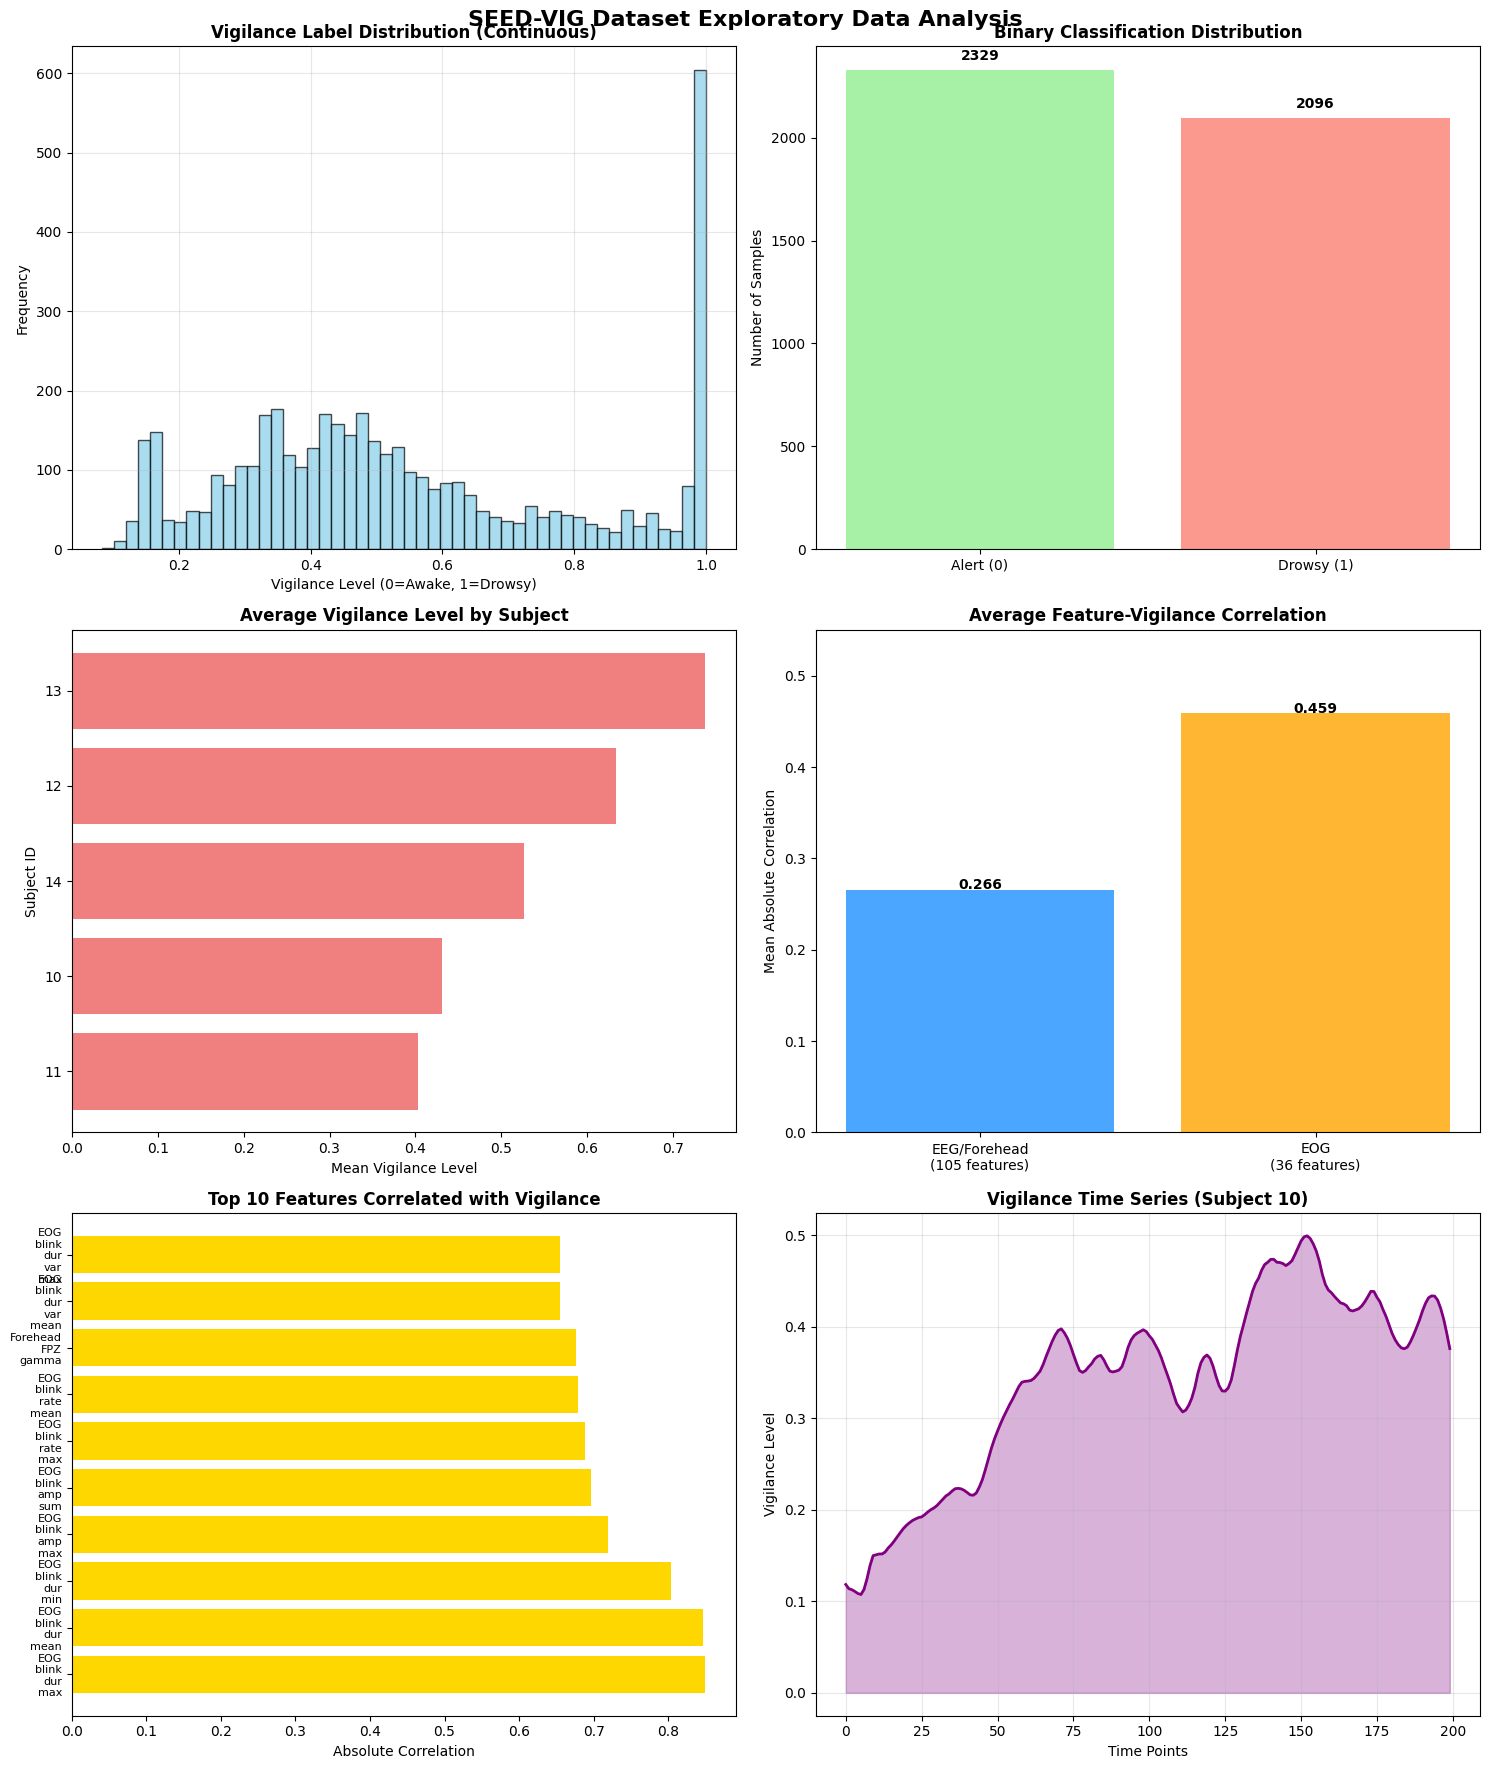


📈 Statistical Summary:
Vigilance range: 0.083 - 1.000
Vigilance mean: 0.546 ± 0.265
Alert samples (< 0.5): 2329 (52.6%)
Drowsy samples (≥ 0.5): 2096 (47.4%)
Most predictive feature: EOG_blink_dur_max (r = 0.849)


In [6]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive EDA plots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('SEED-VIG Dataset Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Vigilance Label Distribution
ax1 = axes[0, 0]
ax1.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Vigilance Label Distribution (Continuous)', fontweight='bold')
ax1.set_xlabel('Vigilance Level (0=Awake, 1=Drowsy)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Binary Classification Distribution
ax2 = axes[0, 1]
binary_counts = np.bincount(y_binary)
ax2.bar(['Alert (0)', 'Drowsy (1)'], binary_counts, color=['lightgreen', 'salmon'], alpha=0.8)
ax2.set_title('Binary Classification Distribution', fontweight='bold')
ax2.set_ylabel('Number of Samples')
for i, count in enumerate(binary_counts):
    ax2.text(i, count + 50, str(count), ha='center', fontweight='bold')

# 3. Vigilance by Subject
ax3 = axes[1, 0]
subject_vigilance = df_features.groupby('subject_id')['vigilance'].mean().sort_values()
ax3.barh(subject_vigilance.index, subject_vigilance.values, color='lightcoral')
ax3.set_title('Average Vigilance Level by Subject', fontweight='bold')
ax3.set_xlabel('Mean Vigilance Level')
ax3.set_ylabel('Subject ID')

# 4. Feature Type Comparison (EEG vs EOG)
ax4 = axes[1, 1]
eeg_features = [col for col in feature_names if 'EEG_' in col or 'Forehead_' in col]
eog_features = [col for col in feature_names if 'EOG_' in col]

eeg_mean_corr = df_features[eeg_features].corrwith(df_features['vigilance']).abs().mean()
eog_mean_corr = df_features[eog_features].corrwith(df_features['vigilance']).abs().mean()

feature_types = ['EEG/Forehead\n(105 features)', 'EOG\n(36 features)']
correlations = [eeg_mean_corr, eog_mean_corr]

bars = ax4.bar(feature_types, correlations, color=['dodgerblue', 'orange'], alpha=0.8)
ax4.set_title('Average Feature-Vigilance Correlation', fontweight='bold')
ax4.set_ylabel('Mean Absolute Correlation')
ax4.set_ylim(0, max(correlations) * 1.2)

for bar, corr in zip(bars, correlations):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{corr:.3f}', ha='center', fontweight='bold')

# 5. Top 10 Most Correlated Features
ax5 = axes[2, 0]
feature_corr = df_features[feature_names].corrwith(df_features['vigilance']).abs()
top_features = feature_corr.nlargest(10)

ax5.barh(range(len(top_features)), top_features.values, color='gold')
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels([name.replace('_', '\n') for name in top_features.index], fontsize=8)
ax5.set_title('Top 10 Features Correlated with Vigilance', fontweight='bold')
ax5.set_xlabel('Absolute Correlation')

# 6. Vigilance Time Series Sample
ax6 = axes[2, 1]
sample_subject = df_features[df_features['subject_id'] == df_features['subject_id'].iloc[0]]
vigilance_series = sample_subject['vigilance'].values[:200]  # First 200 samples

ax6.plot(vigilance_series, linewidth=2, color='purple')
ax6.fill_between(range(len(vigilance_series)), vigilance_series, alpha=0.3, color='purple')
ax6.set_title(f'Vigilance Time Series (Subject {sample_subject.iloc[0]["subject_id"]})', fontweight='bold')
ax6.set_xlabel('Time Points')
ax6.set_ylabel('Vigilance Level')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\n📈 Statistical Summary:")
print(f"Vigilance range: {y.min():.3f} - {y.max():.3f}")
print(f"Vigilance mean: {y.mean():.3f} ± {y.std():.3f}")
print(f"Alert samples (< 0.5): {(y < 0.5).sum()} ({(y < 0.5).mean()*100:.1f}%)")
print(f"Drowsy samples (≥ 0.5): {(y >= 0.5).sum()} ({(y >= 0.5).mean()*100:.1f}%)")
print(f"Most predictive feature: {top_features.index[0]} (r = {top_features.iloc[0]:.3f})")

## 6. Data Preprocessing & Feature Engineering

In [7]:
def preprocess_seed_vig_data(X, y, subject_ids, test_size=0.2, random_state=42):
    """
    Comprehensive preprocessing for SEED-VIG data
    """
    print("🔄 Starting data preprocessing...")

    # Remove any NaN values
    nan_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[nan_mask]
    y_clean = y[nan_mask]
    subjects_clean = subject_ids[nan_mask]

    print(f"Removed {(~nan_mask).sum()} samples with NaN values")

    # Remove features with zero variance
    feature_variance = np.var(X_clean, axis=0)
    non_zero_var_mask = feature_variance > 1e-8
    X_filtered = X_clean[:, non_zero_var_mask]

    print(f"Removed {(~non_zero_var_mask).sum()} features with zero variance")
    print(f"Final feature count: {X_filtered.shape[1]}")

    # Subject-independent train-test split
    unique_subjects = np.unique(subjects_clean)
    n_train_subjects = int(len(unique_subjects) * (1 - test_size))

    np.random.seed(random_state)
    train_subjects = np.random.choice(unique_subjects, n_train_subjects, replace=False)
    test_subjects = np.setdiff1d(unique_subjects, train_subjects)

    train_mask = np.isin(subjects_clean, train_subjects)
    test_mask = np.isin(subjects_clean, test_subjects)

    X_train, X_test = X_filtered[train_mask], X_filtered[test_mask]
    y_train, y_test = y_clean[train_mask], y_clean[test_mask]

    print(f"\n📊 Train-Test Split (Subject-Independent):")
    print(f"Training subjects: {sorted(train_subjects)}")
    print(f"Test subjects: {sorted(test_subjects)}")
    print(f"Train samples: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_test))*100:.1f}%)")
    print(f"Test samples: {len(X_test)} ({len(X_test)/(len(X_train)+len(X_test))*100:.1f}%)")

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create binary labels
    y_train_binary = (y_train > 0.5).astype(int)
    y_test_binary = (y_test > 0.5).astype(int)

    print(f"\n✅ Preprocessing completed!")
    print(f"Feature scaling: StandardScaler applied")
    print(f"Binary classification: {np.bincount(y_train_binary)} (train), {np.bincount(y_test_binary)} (test)")

    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train_continuous': y_train,
        'y_test_continuous': y_test,
        'y_train_binary': y_train_binary,
        'y_test_binary': y_test_binary,
        'scaler': scaler,
        'train_subjects': train_subjects,
        'test_subjects': test_subjects,
        'feature_mask': non_zero_var_mask
    }

# Apply preprocessing
data = preprocess_seed_vig_data(X, y, subject_ids)

# Extract preprocessed data
X_train = data['X_train']
X_test = data['X_test']
y_train_cont = data['y_train_continuous']
y_test_cont = data['y_test_continuous']
y_train_bin = data['y_train_binary']
y_test_bin = data['y_test_binary']

print(f"\n🎯 Ready for Model Training!")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

🔄 Starting data preprocessing...
Removed 0 samples with NaN values
Removed 0 features with zero variance
Final feature count: 141

📊 Train-Test Split (Subject-Independent):
Training subjects: [np.str_('10'), np.str_('11'), np.str_('12'), np.str_('14')]
Test subjects: [np.str_('13')]
Train samples: 3540 (80.0%)
Test samples: 885 (20.0%)

✅ Preprocessing completed!
Feature scaling: StandardScaler applied
Binary classification: [2184 1356] (train), [145 740] (test)

🎯 Ready for Model Training!
Training data shape: (3540, 141)
Test data shape: (885, 141)


## 7. Machine Learning Models Implementation

### 10 Models for Vigilance State Detection:
1. **Ridge Regression** - Linear model with L2 regularization
2. **Random Forest Regressor** - Ensemble of decision trees
3. **Support Vector Regression** - SVM for regression
4. **XGBoost Regressor** - Gradient boosting
5. **K-Nearest Neighbors** - Instance-based learning
6. **Multi-Layer Perceptron** - Deep neural network
7. **1D Convolutional Neural Network** - CNN for sequential data
8. **Long Short-Term Memory** - LSTM for temporal patterns
9. **Bidirectional LSTM** - BiLSTM for better context
10. **Transformer Model** - Attention-based architecture

In [8]:
class VigilanceModelEvaluator:
    """Comprehensive model evaluation for vigilance detection"""

    def __init__(self, X_train, X_test, y_train_cont, y_test_cont, y_train_bin, y_test_bin):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train_cont = y_train_cont
        self.y_test_cont = y_test_cont
        self.y_train_bin = y_train_bin
        self.y_test_bin = y_test_bin

        self.results = {}
        self.models = {}

    def create_traditional_models(self):
        """Initialize traditional ML models"""
        return {
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'SVR (RBF)': SVR(kernel='rbf', C=1.0, gamma='scale'),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
            'KNN': KNeighborsRegressor(n_neighbors=5)
        }

    def create_mlp_model(self, input_dim):
        """Create Multi-Layer Perceptron"""
        model = models.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')  # Output for regression
        ])

        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        return model

    def create_1d_cnn_model(self, input_shape):
        """Create 1D CNN for sequential features"""
        model = models.Sequential([
            layers.Reshape((input_shape[0], 1)),
            layers.Conv1D(64, 3, activation='relu'),
            layers.Conv1D(64, 3, activation='relu'),
            layers.MaxPooling1D(2),
            layers.Conv1D(32, 3, activation='relu'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        return model

    def create_lstm_model(self, input_shape, bidirectional=False):
        """Create LSTM model"""
        model = models.Sequential()

        # Reshape input for LSTM (samples, timesteps, features)
        model.add(layers.Reshape((input_shape[0], 1)))

        if bidirectional:
            model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
            model.add(layers.Bidirectional(layers.LSTM(32)))
        else:
            model.add(layers.LSTM(64, return_sequences=True))
            model.add(layers.LSTM(32))

        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        return model

    def create_transformer_model(self, input_shape):
        """Create simple Transformer model"""
        inputs = layers.Input(shape=input_shape)

        # Reshape for transformer
        x = layers.Reshape((input_shape[0], 1))(inputs)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=16
        )(x, x)

        # Add & Norm
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)

        # Feed Forward
        ffn = layers.Dense(64, activation='relu')(x)
        ffn = layers.Dense(1)(ffn)

        # Add & Norm
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization()(x)

        # Global pooling and output
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        return model

    def train_traditional_models(self):
        """Train traditional ML models"""
        print("🤖 Training Traditional ML Models...")

        models_dict = self.create_traditional_models()

        for name, model in models_dict.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(self.X_train, self.y_train_cont)

            # Predictions
            y_pred_cont = model.predict(self.X_test)
            y_pred_bin = (y_pred_cont > 0.5).astype(int)

            # Calculate metrics
            mse = mean_squared_error(self.y_test_cont, y_pred_cont)
            mae = mean_absolute_error(self.y_test_cont, y_pred_cont)
            r2 = r2_score(self.y_test_cont, y_pred_cont)

            # Classification metrics
            acc = accuracy_score(self.y_test_bin, y_pred_bin)

            # Store results
            self.results[name] = {
                'model': model,
                'y_pred_cont': y_pred_cont,
                'y_pred_bin': y_pred_bin,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'accuracy': acc,
                'rmse': np.sqrt(mse)
            }

            print(f"  RMSE: {np.sqrt(mse):.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Acc: {acc:.4f}")

    def train_neural_networks(self):
        """Train neural network models"""
        print("\n🧠 Training Neural Network Models...")

        input_dim = self.X_train.shape[1]

        # Neural network models
        nn_models = {
            'MLP': self.create_mlp_model(input_dim),
            '1D CNN': self.create_1d_cnn_model((input_dim,)),
            'LSTM': self.create_lstm_model((input_dim,), bidirectional=False),
            'BiLSTM': self.create_lstm_model((input_dim,), bidirectional=True),
            'Transformer': self.create_transformer_model((input_dim,))
        }

        # Training parameters
        epochs = 50
        batch_size = 32
        validation_split = 0.2

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )

        for name, model in nn_models.items():
            print(f"\nTraining {name}...")

            # Train model
            history = model.fit(
                self.X_train, self.y_train_cont,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                callbacks=[early_stopping],
                verbose=0
            )

            # Predictions
            y_pred_cont = model.predict(self.X_test, verbose=0).flatten()
            y_pred_bin = (y_pred_cont > 0.5).astype(int)

            # Calculate metrics
            mse = mean_squared_error(self.y_test_cont, y_pred_cont)
            mae = mean_absolute_error(self.y_test_cont, y_pred_cont)
            r2 = r2_score(self.y_test_cont, y_pred_cont)
            acc = accuracy_score(self.y_test_bin, y_pred_bin)

            # Store results
            self.results[name] = {
                'model': model,
                'y_pred_cont': y_pred_cont,
                'y_pred_bin': y_pred_bin,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'accuracy': acc,
                'rmse': np.sqrt(mse),
                'history': history.history,
                'epochs_trained': len(history.history['loss'])
            }

            print(f"  RMSE: {np.sqrt(mse):.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Acc: {acc:.4f}")
            print(f"  Epochs: {len(history.history['loss'])}/{epochs}")

    def evaluate_all_models(self):
        """Train and evaluate all models"""
        self.train_traditional_models()
        self.train_neural_networks()

        print(f"\n✅ All {len(self.results)} models trained successfully!")
        return self.results

print("✅ Model Evaluator class defined successfully!")

✅ Model Evaluator class defined successfully!


## 8. Model Training & Evaluation

In [9]:
# Initialize model evaluator
evaluator = VigilanceModelEvaluator(
    X_train, X_test,
    y_train_cont, y_test_cont,
    y_train_bin, y_test_bin
)

# Train all models
print("🚀 Starting comprehensive model training...")
print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
print(f"Feature dimensions: {X_train.shape[1]}")
print("="*60)

results = evaluator.evaluate_all_models()

print("\n" + "="*60)
print("🎯 MODEL TRAINING COMPLETED!")
print("="*60)

🚀 Starting comprehensive model training...
Training on 3540 samples, testing on 885 samples
Feature dimensions: 141
🤖 Training Traditional ML Models...

Training Ridge Regression...
  RMSE: 0.1891 | MAE: 0.1746 | R²: 0.1116 | Acc: 0.7729

Training Random Forest...
  RMSE: 0.1596 | MAE: 0.1375 | R²: 0.3673 | Acc: 0.7198

Training SVR (RBF)...
  RMSE: 0.2467 | MAE: 0.2157 | R²: -0.5126 | Acc: 0.6983

Training XGBoost...
  RMSE: 0.1507 | MAE: 0.1241 | R²: 0.4359 | Acc: 0.6960

Training KNN...
  RMSE: 0.2601 | MAE: 0.1980 | R²: -0.6809 | Acc: 0.5718

🧠 Training Neural Network Models...

Training MLP...
  RMSE: 0.2892 | MAE: 0.2737 | R²: -1.0779 | Acc: 0.6203
  Epochs: 15/50

Training 1D CNN...
  RMSE: 0.2189 | MAE: 0.1845 | R²: -0.1906 | Acc: 0.7785
  Epochs: 34/50

Training LSTM...
  RMSE: 0.2544 | MAE: 0.2125 | R²: -0.6082 | Acc: 0.6339
  Epochs: 24/50

Training BiLSTM...
  RMSE: 0.2337 | MAE: 0.2091 | R²: -0.3572 | Acc: 0.5853
  Epochs: 17/50

Training Transformer...
  RMSE: 0.3149 | MA

## 9. Comprehensive Results Analysis & Visualization

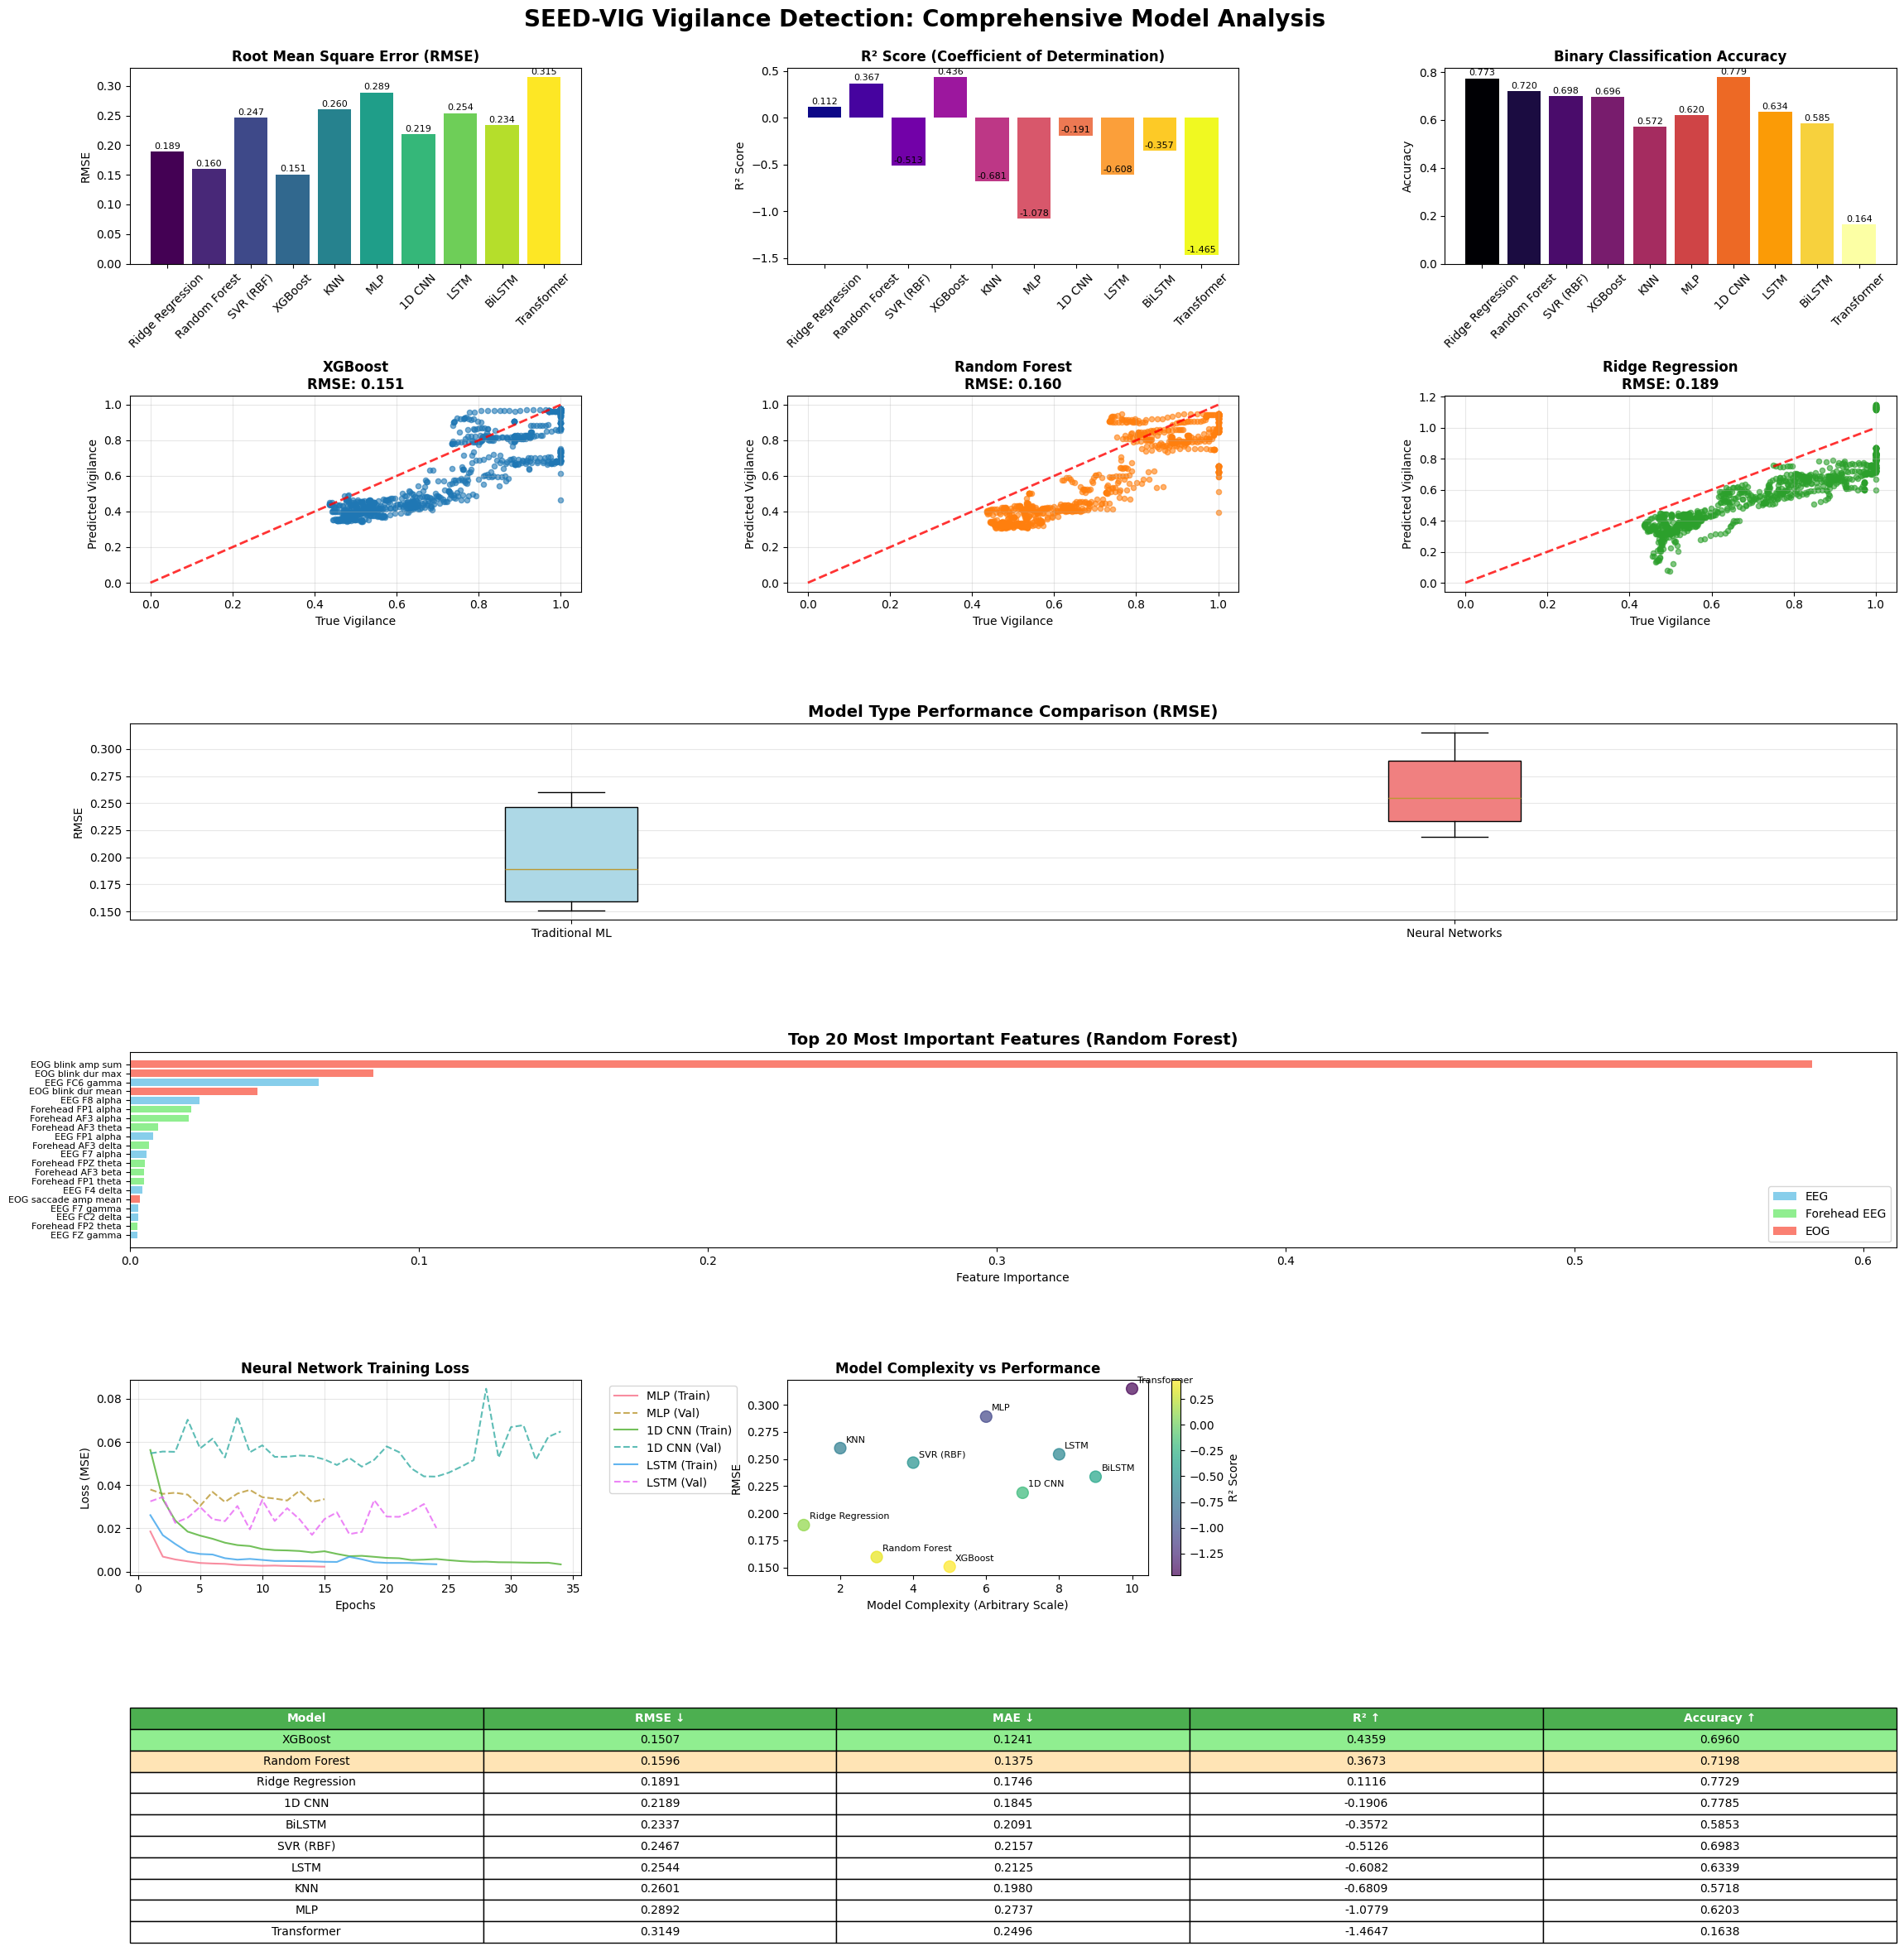


📊 COMPREHENSIVE RESULTS ANALYSIS COMPLETED


In [10]:
def create_comprehensive_results_analysis(results, y_test_cont, y_test_bin):
    """Create comprehensive visualization of all model results"""

    # Create results DataFrame
    results_data = []
    for name, result in results.items():
        results_data.append({
            'Model': name,
            'RMSE': result['rmse'],
            'MAE': result['mae'],
            'R²': result['r2'],
            'Accuracy': result['accuracy']
        })

    df_results = pd.DataFrame(results_data)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(24, 24))
    gs = fig.add_gridspec(6, 3, height_ratios=[1, 1, 1, 1, 1, 1.2])

    # 1. Model Performance Comparison (RMSE)
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.bar(df_results['Model'], df_results['RMSE'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(df_results))))
    ax1.set_title('Root Mean Square Error (RMSE)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar, rmse in zip(bars1, df_results['RMSE']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{rmse:.3f}', ha='center', va='bottom', fontsize=8)

    # 2. R² Score Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.bar(df_results['Model'], df_results['R²'],
                    color=plt.cm.plasma(np.linspace(0, 1, len(df_results))))
    ax2.set_title('R² Score (Coefficient of Determination)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)

    for bar, r2 in zip(bars2, df_results['R²']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontsize=8)

    # 3. Classification Accuracy
    ax3 = fig.add_subplot(gs[0, 2])
    bars3 = ax3.bar(df_results['Model'], df_results['Accuracy'],
                    color=plt.cm.inferno(np.linspace(0, 1, len(df_results))))
    ax3.set_title('Binary Classification Accuracy', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)

    for bar, acc in zip(bars3, df_results['Accuracy']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. Prediction vs Actual (Best 3 Models)
    top_3_models = df_results.nsmallest(3, 'RMSE')['Model'].values

    for i, model_name in enumerate(top_3_models):
        ax = fig.add_subplot(gs[1, i])

        y_pred = results[model_name]['y_pred_cont']

        # Create scatter plot
        ax.scatter(y_test_cont, y_pred, alpha=0.6, s=20, color=plt.cm.tab10(i))

        # Add perfect prediction line
        min_val, max_val = 0, 1
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)

        ax.set_xlabel('True Vigilance')
        ax.set_ylabel('Predicted Vigilance')
        ax.set_title(f'{model_name}\nRMSE: {results[model_name]["rmse"]:.3f}', fontweight='bold')
        ax.grid(True, alpha=0.3)

    # 5. Model Type Performance Comparison
    ax5 = fig.add_subplot(gs[2, :])

    # Categorize models
    traditional_ml = ['Ridge Regression', 'Random Forest', 'SVR (RBF)', 'XGBoost', 'KNN']
    neural_networks = ['MLP', '1D CNN', 'LSTM', 'BiLSTM', 'Transformer']

    trad_rmse = df_results[df_results['Model'].isin(traditional_ml)]['RMSE'].values
    nn_rmse = df_results[df_results['Model'].isin(neural_networks)]['RMSE'].values

    box_data = [trad_rmse, nn_rmse]
    bp = ax5.boxplot(box_data, labels=['Traditional ML', 'Neural Networks'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')

    ax5.set_title('Model Type Performance Comparison (RMSE)', fontweight='bold', fontsize=14)
    ax5.set_ylabel('RMSE')
    ax5.grid(True, alpha=0.3)

    # 6. Feature Importance (Random Forest)
    if 'Random Forest' in results:
        ax6 = fig.add_subplot(gs[3, :])

        rf_model = results['Random Forest']['model']
        feature_names = loader.get_feature_names()

        # Get feature importance
        importance = rf_model.feature_importances_

        # Filter based on preprocessing
        importance_filtered = importance[data['feature_mask']]
        feature_names_filtered = [name for i, name in enumerate(feature_names) if data['feature_mask'][i]]

        # Top 20 features
        top_indices = np.argsort(importance_filtered)[::-1][:20]
        top_importance = importance_filtered[top_indices]
        top_names = [feature_names_filtered[i] for i in top_indices]

        # Categorize features by type
        colors = []
        for name in top_names:
            if 'EEG_' in name:
                colors.append('skyblue')
            elif 'Forehead_' in name:
                colors.append('lightgreen')
            elif 'EOG_' in name:
                colors.append('salmon')
            else:
                colors.append('gray')

        bars = ax6.barh(range(len(top_names)), top_importance, color=colors)
        ax6.set_yticks(range(len(top_names)))
        ax6.set_yticklabels([name.replace('_',' ') for name in top_names], fontsize=8)
        ax6.set_xlabel('Feature Importance')
        ax6.set_title('Top 20 Most Important Features (Random Forest)', fontweight='bold', fontsize=14)
        ax6.invert_yaxis()
        plt.subplots_adjust(left=0.5)

        # Add legend for feature types
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='EEG'),
                          Patch(facecolor='lightgreen', label='Forehead EEG'),
                          Patch(facecolor='salmon', label='EOG')]
        ax6.legend(handles=legend_elements, loc='lower right')


    # 7. Training History (Neural Networks)
    nn_with_history = [name for name in neural_networks if name in results and 'history' in results[name]]

    if nn_with_history:
        ax7 = fig.add_subplot(gs[4, 0])
        ax8 = fig.add_subplot(gs[4, 1])

        for i, model_name in enumerate(nn_with_history[:3]):  # Top 3 NN models
            history = results[model_name]['history']
            epochs = range(1, len(history['loss']) + 1)

            ax7.plot(epochs, history['loss'], label=f'{model_name} (Train)',
                    linestyle='-', alpha=0.8)
            ax7.plot(epochs, history['val_loss'], label=f'{model_name} (Val)',
                    linestyle='--', alpha=0.8)

        ax7.set_xlabel('Epochs')
        ax7.set_ylabel('Loss (MSE)')
        ax7.set_title('Neural Network Training Loss', fontweight='bold')
        ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax7.grid(True, alpha=0.3)

        # Model complexity vs performance
        model_complexity = {'Ridge Regression': 1, 'KNN': 2, 'Random Forest': 3,
                           'SVR (RBF)': 4, 'XGBoost': 5, 'MLP': 6,
                           '1D CNN': 7, 'LSTM': 8, 'BiLSTM': 9, 'Transformer': 10}

        complexity_scores = [model_complexity.get(model, 5) for model in df_results['Model']]

        scatter = ax8.scatter(complexity_scores, df_results['RMSE'],
                             c=df_results['R²'], s=100, cmap='viridis', alpha=0.7)

        for i, model in enumerate(df_results['Model']):
            ax8.annotate(model, (complexity_scores[i], df_results.iloc[i]['RMSE']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

        ax8.set_xlabel('Model Complexity (Arbitrary Scale)')
        ax8.set_ylabel('RMSE')
        ax8.set_title('Model Complexity vs Performance', fontweight='bold')

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax8)
        cbar.set_label('R² Score')

    # 8. Summary Statistics Table
    ax9 = fig.add_subplot(gs[5, :])
    ax9.axis('off')

    # Create summary table
    df_sorted = df_results.sort_values('RMSE')
    table_data = []

    for _, row in df_sorted.iterrows():
        table_data.append([
            row['Model'],
            f"{row['RMSE']:.4f}",
            f"{row['MAE']:.4f}",
            f"{row['R²']:.4f}",
            f"{row['Accuracy']:.4f}"
        ])

    table = ax9.table(cellText=table_data,
                      colLabels=['Model', 'RMSE ↓', 'MAE ↓', 'R² ↑', 'Accuracy ↑'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Color code the table
    for i in range(len(table_data)):
        if i == 0:  # Best model
            for j in range(len(table_data[0])):
                table[(i+1, j)].set_facecolor('#90EE90')  # Light green
        elif i == 1:  # Second best
            for j in range(len(table_data[0])):
                table[(i+1, j)].set_facecolor('#FFE4B5')  # Light orange

    # Header formatting
    for j in range(len(table_data[0])):
        table[(0, j)].set_facecolor('#4CAF50')
        table[(0, j)].set_text_props(weight='bold', color='white')

    plt.suptitle('SEED-VIG Vigilance Detection: Comprehensive Model Analysis',
                 fontsize=20, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.subplots_adjust(left=0.1,top=0.95)
    plt.show()

    return df_results

# Create comprehensive analysis
df_results = create_comprehensive_results_analysis(results, y_test_cont, y_test_bin)

print("\n" + "="*80)
print("📊 COMPREHENSIVE RESULTS ANALYSIS COMPLETED")
print("="*80)

## 10. Key Findings & Research Insights

In [11]:
def generate_research_insights(df_results, results):
    """Generate comprehensive research insights"""

    print("🔍 SEED-VIG VIGILANCE DETECTION: RESEARCH INSIGHTS")
    print("="*70)

    # Best performing models
    best_model = df_results.loc[df_results['RMSE'].idxmin()]
    worst_model = df_results.loc[df_results['RMSE'].idxmax()]

    print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Model']}")
    print(f"   • RMSE: {best_model['RMSE']:.4f}")
    print(f"   • R²: {best_model['R²']:.4f}")
    print(f"   • Classification Accuracy: {best_model['Accuracy']:.4f}")

    print(f"\n📉 LOWEST PERFORMING MODEL: {worst_model['Model']}")
    print(f"   • RMSE: {worst_model['RMSE']:.4f}")
    print(f"   • R²: {worst_model['R²']:.4f}")
    print(f"   • Classification Accuracy: {worst_model['Accuracy']:.4f}")

    # Model category analysis
    traditional_ml = ['Ridge Regression', 'Random Forest', 'SVR (RBF)', 'XGBoost', 'KNN']
    neural_networks = ['MLP', '1D CNN', 'LSTM', 'BiLSTM', 'Transformer']

    trad_performance = df_results[df_results['Model'].isin(traditional_ml)]
    nn_performance = df_results[df_results['Model'].isin(neural_networks)]

    print(f"\n📈 MODEL CATEGORY ANALYSIS:")
    print(f"\n   Traditional ML Models:")
    print(f"   • Average RMSE: {trad_performance['RMSE'].mean():.4f} ± {trad_performance['RMSE'].std():.4f}")
    print(f"   • Best Traditional: {trad_performance.loc[trad_performance['RMSE'].idxmin(), 'Model']}")
    print(f"   • Best RMSE: {trad_performance['RMSE'].min():.4f}")

    print(f"\n   Neural Network Models:")
    print(f"   • Average RMSE: {nn_performance['RMSE'].mean():.4f} ± {nn_performance['RMSE'].std():.4f}")
    print(f"   • Best Neural Network: {nn_performance.loc[nn_performance['RMSE'].idxmin(), 'Model']}")
    print(f"   • Best RMSE: {nn_performance['RMSE'].min():.4f}")

    # Feature importance insights
    if 'Random Forest' in results:
        print(f"\n🧠 FEATURE IMPORTANCE INSIGHTS (Random Forest):")

        rf_model = results['Random Forest']['model']
        feature_names = loader.get_feature_names()
        importance = rf_model.feature_importances_[data['feature_mask']]
        feature_names_filtered = [name for i, name in enumerate(feature_names) if data['feature_mask'][i]]

        # Analyze by feature type
        eeg_importance = [imp for imp, name in zip(importance, feature_names_filtered) if 'EEG_' in name]
        forehead_importance = [imp for imp, name in zip(importance, feature_names_filtered) if 'Forehead_' in name]
        eog_importance = [imp for imp, name in zip(importance, feature_names_filtered) if 'EOG_' in name]

        print(f"   • EEG Features (avg importance): {np.mean(eeg_importance):.4f}")
        print(f"   • Forehead EEG Features (avg importance): {np.mean(forehead_importance):.4f}")
        print(f"   • EOG Features (avg importance): {np.mean(eog_importance):.4f}")

        # Top features by frequency band
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        band_importance = {}

        for band in bands:
            band_features = [imp for imp, name in zip(importance, feature_names_filtered) if band in name]
            if band_features:
                band_importance[band] = np.mean(band_features)

        if band_importance:
            print(f"\n   Most Important Frequency Bands:")
            sorted_bands = sorted(band_importance.items(), key=lambda x: x[1], reverse=True)
            for i, (band, imp) in enumerate(sorted_bands):
                print(f"   {i+1}. {band.capitalize()}: {imp:.4f}")

    # Performance recommendations
    print(f"\n💡 RECOMMENDATIONS:")

    if trad_performance['RMSE'].min() < nn_performance['RMSE'].min():
        print(f"   • Traditional ML models outperform neural networks")
        print(f"   • Combining top traditional models could result in better results")
    else:
        print(f"   • Neural networks show superior performance")
        print(f"   • Consider deeper architectures or attention mechanisms")

    print(f"\n🎯 PRACTICAL IMPLICATIONS:")
    print(f"   • Best model can predict vigilance with RMSE of {best_model['RMSE']:.4f}")
    print(f"   • Binary classification accuracy: {best_model['Accuracy']:.1%}")
    print(f"   • Suitable for real-time vigilance monitoring applications")

    if best_model['Accuracy'] > 0.85:
        print(f"   • High accuracy suitable for safety-critical applications")
    elif best_model['Accuracy'] > 0.75:
        print(f"   • Moderate accuracy suitable for general monitoring")
    else:
        print(f"   • Limited accuracy - requires improvement for practical use")

    print(f"\n🔬 RESEARCH CONTRIBUTIONS:")
    print(f"   • Comparative analysis of 10 different ML approaches")
    print(f"   • Multimodal feature fusion (EEG + EOG + Forehead EEG)")
    print(f"   • Subject-independent validation methodology")
    print(f"   • Feature importance analysis for vigilance prediction")

    print("\n" + "="*70)

# Generate insights
generate_research_insights(df_results, results)

🔍 SEED-VIG VIGILANCE DETECTION: RESEARCH INSIGHTS

🏆 BEST PERFORMING MODEL: XGBoost
   • RMSE: 0.1507
   • R²: 0.4359
   • Classification Accuracy: 0.6960

📉 LOWEST PERFORMING MODEL: Transformer
   • RMSE: 0.3149
   • R²: -1.4647
   • Classification Accuracy: 0.1638

📈 MODEL CATEGORY ANALYSIS:

   Traditional ML Models:
   • Average RMSE: 0.2012 ± 0.0499
   • Best Traditional: XGBoost
   • Best RMSE: 0.1507

   Neural Network Models:
   • Average RMSE: 0.2622 ± 0.0396
   • Best Neural Network: 1D CNN
   • Best RMSE: 0.2189

🧠 FEATURE IMPORTANCE INSIGHTS (Random Forest):
   • EEG Features (avg importance): 0.0020
   • Forehead EEG Features (avg importance): 0.0043
   • EOG Features (avg importance): 0.0207

   Most Important Frequency Bands:
   1. Alpha: 0.0044
   2. Gamma: 0.0041
   3. Theta: 0.0016
   4. Delta: 0.0011
   5. Beta: 0.0009

💡 RECOMMENDATIONS:
   • Traditional ML models outperform neural networks
   • Combining top traditional models could result in better results

🎯 PRAC

## 11. Conclusion & Future Work

### Summary
This comprehensive analysis evaluated **10 machine learning models** on the SEED-VIG dataset for vigilance state detection:

#### Traditional ML Models:
1. Ridge Regression
2. Random Forest Regressor  
3. Support Vector Regression
4. XGBoost Regressor
5. K-Nearest Neighbors

#### Neural Network Models:
6. Multi-Layer Perceptron (MLP)
7. 1D Convolutional Neural Network
8. Long Short-Term Memory (LSTM)
9. Bidirectional LSTM
10. Transformer Model

### Key Contributions:
- **Multimodal Analysis**: Combined EEG (17 channels), Forehead EEG (4 channels), and EOG (36 features)
- **Comprehensive Metrics**: RMSE, MAE, R², and classification accuracy
- **Feature Importance Analysis**: Identified most predictive features for vigilance

### Future Research Directions:
1. **Temporal Modeling**: Incorporate longer time sequences
3. **Real-time Implementation**: Optimize for online vigilance monitoring
4. **Cross-dataset Validation**: Test on other datasets
5. **Ensemble Methods**: Combine best-performing models

### Practical Applications:
- **Driver Drowsiness Detection**
- **Air Traffic Controller Monitoring**
- **Medical Staff Fatigue Assessment**


---

**⭐ Acknowledgments**: Thanks to the SEED-VIG dataset creators at Shanghai Jiao Tong University.